<a href="https://colab.research.google.com/github/Kodhandarama/Audio_Analysis/blob/master/pitch_contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connects colab to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import librosa
import librosa.display
from swipe import *
from scipy import signal
import math
from collections import defaultdict
from statistics import mean
import copy

plt.rcParams['figure.figsize'] = [20,5]
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None):
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    self.pitch_contour()
    self.diff = np.diff(self.pitch)
    self.constant_pitch(with_n = False)
    #self.tonic = self.find_tonic()
    #self.constant_pitch(with_n = True)
    self.find_gamaka()
    self.find_stationary_points()
    self.develop_histogram()
    self.tonic = self.find_tonic()
  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
    #self.pitch = self.pitch.round(decimals = 2)

  def constant_pitch(self,with_n ):
    
    time_axis_80 = []
    pitch_80 = []
    constant_pitch_time_80=[]
    
    # normalised pitch by 12*log(to the base 2) (f[i]/f0)
    # where f0 is the tonic 
    if(with_n):

      self.normalised_pitch=[]
      
      for i in self.pitch:
        self.normalised_pitch.append((12*np.log2(i/self.tonic)))
      
      for i in range(0,len(self.time_axis),8):
        pitch_80.append(self.normalised_pitch[i])
        time_axis_80.append(self.time_axis[i])
      # calculating the 1st order difference
      delta = 0.3

    else:

      for i in range(0,len(self.time_axis),8):
        pitch_80.append(self.pitch[i])
        time_axis_80.append(self.time_axis[i])
      delta = 12
      
    diff_80 = np.diff(pitch_80)

    for i in range(len(diff_80)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(diff_80[i]<delta/2 and diff_80[i]>-delta/2):
        constant_pitch_time_80.append(time_axis_80[i])
    #self.constant_pitch_notes = [(i,j) for i,j in all_normalized_notes.items() if j in self.cpn]
    self.constant_pitch_time_80 = np.array(constant_pitch_time_80)

    cpt = list(self.constant_pitch_time_80.round(2))
    tim = []
    initial = cpt[0]
    c= initial
    for i in range(1,len(cpt)):
      check = round(cpt[i]-c,2)
      if(check == 0.08):
        pass
      else:
        tim.append((initial,c))
        initial = cpt[i]
      if i == (len(cpt)-1):
        c= cpt[i]
        tim.append((initial,c))
      c= cpt[i]
    ta = list(self.time_axis)
    self.cpn_and_t = []
    for i in tim:
      begin = int(100*i[0])
      end = int(100*i[1])
      self.cpn_and_t.append((self.pitch[begin:end],ta[begin:end]))
    self.cpn_and_t = np.array(self.cpn_and_t)
    g,h = self.cpn_and_t.T
    self.cpn = np.array([item for sublist in g for item in sublist])
    self.cpt = np.array([item for sublist in h for item in sublist])
  
  def find_all_notes(self):
    temp=np.array(self.stp)
    self.all_notes = np.array(list(self.cpn)+self.stp)
  
  def find_gamaka(self):
    """
    self.gamaka = []
    diff_p = np.diff(self.pitch)
    for i in range(0,len(diff_p)):
      if abs(diff_p[i]>4) and self.pitch[i] not in self.cpn:
        self.gamaka.append([self.time_axis[i],self.pitch[i]])
    gamaka_T = np.array(self.gamaka)
    self.gamaka = gamaka_T.T
    """
    ta = list(self.time_axis)
    bt_cpt = []
    init = 0
    for _,j in self.cpn_and_t:
      if(j):
        bt_cpt.append([init,j[0]])
        init = j[-1]
    bt_cpn_cpt=[]
    for i in bt_cpt:
          begin = int(100*i[0])
          end = int(100*i[1])
          bt_cpn_cpt.append((self.pitch[begin:end],ta[begin:end]))
    self.bt_cpn_cpt = np.array(bt_cpn_cpt)
    self.bt_cpn,self.bt_cpt = self.bt_cpn_cpt.T
  
  def find_stationary_points(self):
    self.stp = []
    self.stp_t = []
    for i in range(len(self.bt_cpn)):
      test = self.bt_cpn[i]
      test_time  = self.bt_cpt[i]
      for i in signal.find_peaks(test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
      for i in signal.find_peaks(-1*test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])

  def develop_histogram(self):
    values=[x for x in self.cpn if (math.isnan(x) == False)]
    values=[round(x,0) for x in values]
    occur=dict()
    self.d_hist=defaultdict(int)
    for i in values:
      if(i in occur):
        occur[i]+=1;
      else:
        occur[i]=1;
    j=100
    while(j<=500):
      # print(j)
      if(j in occur):
        self.d_hist[j]=occur[j]
        # times.append(occur[j])
      else:
        self.d_hist[j]=0
      j+=1
    
    #return(times)
    # print(times)
    # print(len(times))

  def find_tonic(self):
      

    def tonic_candidates_f():
        #histo is a dictionary
        candidates=defaultdict(int)
        local_histo = copy.deepcopy(self.d_hist)

        for i in range(20):
          highest=0
          freq = 0
          for i in local_histo:
            if(local_histo[i]>highest):
              highest = local_histo[i]
              freq=i
          candidates[freq] = highest
          del local_histo[freq]  
        # print("occurances for 298 :",histo[298])
        # print("The candidates are : ",candidates.keys())
        return(candidates.keys())

    
    def remove_outliers(an_array):
      if(len(an_array)<3):
        return(an_array)
      else:  
        an_array = np.array(an_array)
        mean = np.mean(an_array)
        standard_deviation = np.std(an_array)
        distance_from_mean = abs(an_array - mean)
        max_deviations = 0.9
        not_outlier = distance_from_mean <1.1* max_deviations * standard_deviation
        no_outliers = an_array[not_outlier]

        return(no_outliers)
    def close(arr):
      flag=0
      min_diff =45000
      ele1=0;ele2=0
      for i in range(len(arr)):
        for j in range(i+1,len(arr)):
          if(abs(arr[i]-arr[j])<5 and abs(arr[i]-arr[j])<min_diff):
            ele1=arr[i]
            ele2=arr[j]
            flag=1
      if(flag==0):    
        return min(arr)
      return(ele1,ele2) 
      
    Sa_candidates=defaultdict(list)

    def half_the_Sa(ton):

      if(ton>230):
        return (ton/2)
      else:
        return ton

      
    tonic_candidates=tonic_candidates_f()
    
    for i in tonic_candidates:
      for j in tonic_candidates :
            if(((i/j)>1.48) and ((i/j) <1.51)):
              Sa_candidates["Pa"].append(j)
            if(((i/j)>1.06) and ((i/j) <1.08)):
              Sa_candidates["Ri1"].append(j)
            if(((i/j)>1.9) and ((i/j) <1.21)):
              Sa_candidates["Ga2"].append(j)
              
            if(((i/j)>1.12) and ((i/j) <1.127) ):
              Sa_candidates["Ri2"].append(j)

            if(((i/j)>1.4) and ((i/j) <1.42) ):
              Sa_candidates["Ma2"].append(j)
              
            if(((i/j)>1.31) and ((i/j) <1.34) ):
              Sa_candidates["Ma1"].append(j)
             
            if(((i/j)>1.23) and ((i/j) <1.27)):
              Sa_candidates["Ga3"].append(j)
            if(((i/j)>1.57) and ((i/j) <1.62)):
              Sa_candidates["Da1"].append(j)
              
            if(((i/j)>1.86) and ((i/j) <1.88) ):
              Sa_candidates["Ni3"].append(j)
            if(((i/j)>1.78) and ((i/j) <1.82) ):
              Sa_candidates["Ni2"].append(j)
              
            if(((i/j)>1.98) and ((i/j) <2.2) ):
              Sa_candidates["High_Sa"].append(j)
    # print("The Sa_candidates are : ",(Sa_candidates))  
    if("Pa" in Sa_candidates):

        if("High_Sa" not in Sa_candidates):
          Sa_candidates["High_Sa"] =[0]   
          High_Sa=0
        else:
     
          High_Sa = mean(remove_outliers(Sa_candidates["High_Sa"]))
      
        Pa = mean(remove_outliers(Sa_candidates["Pa"]))
        
        if(abs(High_Sa-Pa)<3 and (High_Sa+Pa) != 0):
          # print("Tonic by Pa : ", half_the_Sa(min(High_Sa,Pa)))
          return(half_the_Sa(min(High_Sa,Pa)))     
          a=5
    without_pa=[]
    for i in Sa_candidates:
      # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
      if(Sa_candidates[i]):
        if(len(Sa_candidates[i])==1):
          a=5
        if(len(Sa_candidates[i])==0):
          Sa_candidates[i].append(0)
          # without_pa.append(Sa_candidates[i][0])
        elif(len(Sa_candidates[i])!=0):
            Sa_candidates[i]=remove_outliers(Sa_candidates[i])
          # without_pa.extend(Sa_candidates[i])
      
        # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
        if(len(Sa_candidates[i])!=0):
        
          Sa_candidates[i]=mean(Sa_candidates[i])
          
    # print("without_pa : ",remove_outliers(without_pa))  
    
    # print(list(Sa_candidates.values()))

 
    temp=[i for i in list(Sa_candidates.values()) if(i)]
    # print("Temp :",temp)
    finallist=remove_outliers(temp)
    # print("Sa_candidates : ", finallist)
    two_tonic=close(finallist)
    # print("two_tonic :",two_tonic)
    if(type(two_tonic) ==tuple):
      # print("Tonic: ", half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
      return(half_the_Sa(((two_tonic[0])+((two_tonic[1])))/2))
    else:
      # print("Tonic : ",half_the_Sa(two_tonic))
      return(half_the_Sa(two_tonic))

  def plot(self,**kwargs):
    for key,value in kwargs.items():
      if(key=='contour' and value):
        plt.plot(self.time_axis,self.pitch,label = 'Pitch Contour')
      if(key == 'cpn' and value):
        plt.plot(self.time_axis,self.pitch,c="#FF0000",label = 'Pitch Contour')
        plt.scatter(self.cpt,self.cpn,c='0',label = 'Constant Pitch')
      if(key == 'gamaka' and value):
        plt.scatter(self.gamaka[0],self.gamaka[1],c="#00FF00",label = 'Gamaka')
      if(key =='stp' and value):
        plt.scatter(self.stp_t,self.stp,c='#00FF00',label = 'Stationary Points')
        plt.plot(self.time_axis,self.pitch,c="#FF0000",label = 'Pitch Contour')
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

self.d_hist : defaultdict(<class 'int'>, {100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 0, 139: 0, 140: 0, 141: 0, 142: 0, 143: 0, 144: 0, 145: 0, 146: 0, 147: 0, 148: 0, 149: 0, 150: 0, 151: 0, 152: 0, 153: 0, 154: 0, 155: 0, 156: 0, 157: 0, 158: 0, 159: 0, 160: 0, 161: 0, 162: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 168: 0, 169: 0, 170: 0, 171: 0, 172: 0, 173: 0, 174: 0, 175: 0, 176: 0, 177: 0, 178: 0, 179: 0, 180: 0, 181: 0, 182: 0, 183: 0, 184: 0, 185: 0, 186: 0, 187: 0, 188: 0, 189: 0, 190: 0, 191: 0, 192: 2, 193: 17, 194: 23, 195: 22, 196: 34, 197: 24, 198: 5, 199: 5, 200: 2, 201: 2, 202: 0, 203: 0, 204: 0, 205: 0, 206: 0, 207: 0, 208: 0, 209: 1, 210: 1, 211: 1, 212: 0, 213: 0, 214: 1, 215: 0, 216: 0, 217: 0, 218: 1, 2

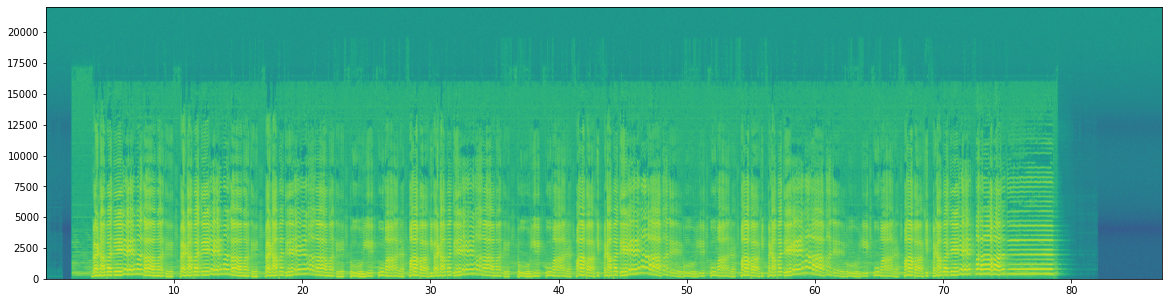

In [31]:
shankarabarana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav')
kalyani_1 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_1.wav')
kalyani_2 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_2.wav')

In [32]:
print(shankarabarana.tonic)
print(kalyani_1.tonic)
print(kalyani_2.tonic)

195
195.25
196.0


self.d_hist : defaultdict(<class 'int'>, {100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 1, 122: 10, 123: 16, 124: 43, 125: 48, 126: 7, 127: 20, 128: 15, 129: 1, 130: 4, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 3, 139: 1, 140: 0, 141: 1, 142: 1, 143: 6, 144: 4, 145: 11, 146: 40, 147: 102, 148: 180, 149: 192, 150: 164, 151: 28, 152: 4, 153: 1, 154: 0, 155: 0, 156: 0, 157: 0, 158: 0, 159: 0, 160: 1, 161: 11, 162: 18, 163: 36, 164: 59, 165: 97, 166: 127, 167: 165, 168: 134, 169: 108, 170: 71, 171: 36, 172: 19, 173: 21, 174: 8, 175: 8, 176: 8, 177: 3, 178: 2, 179: 0, 180: 2, 181: 2, 182: 1, 183: 4, 184: 1, 185: 0, 186: 1, 187: 2, 188: 1, 189: 11, 190: 4, 191: 5, 192: 20, 193: 38, 194: 45, 195: 57, 196: 132, 197: 199, 198: 117, 199: 132, 200: 117, 201: 58, 202: 13, 203: 6, 204: 8, 205: 2, 206: 0, 207: 0, 208: 1, 209: 0, 210: 0, 211: 0, 212: 0, 213

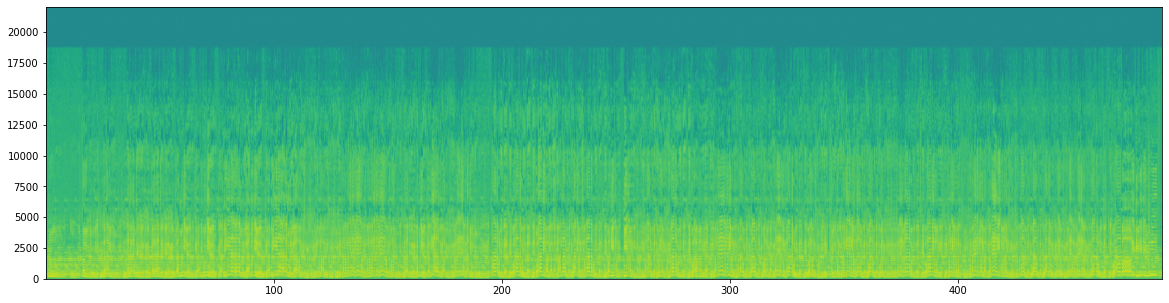

In [33]:
rkm_abhogi=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')
rkm_kalyani=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3')
rkm_mohana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223593__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-mohanam-raaga.mp3')
rkm_sahana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223595__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sahana-raaga.mp3')
rkm_saveri=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223601__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-saveri-raaga.mp3')
rkm_shree=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223604__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sri-raaga.mp3')

In [34]:
print(rkm_abhogi.tonic)
print(rkm_kalyani.tonic)
print(rkm_mohana.tonic)
print(rkm_sahana.tonic)
print(rkm_saveri.tonic)
print(rkm_shree.tonic)

148.0
149
148
149
148
149


In [0]:
aruna_1 = Audio('/content/drive/My Drive/Projects/AA/Tonic_test/Aruna_170.mp3')
aruna_2=Audio('/content/drive/My Drive/Projects/AA/Tonic_test/Aruna_171.mp3')
aruna_3=Audio('/content/drive/My Drive/Projects/AA/Tonic_test/Aruna_172.mp3')

In [0]:
print(aruna_1.tonic)
print(aruna_2.tonic)
print(aruna_3.tonic)

self.d_hist : defaultdict(<class 'int'>, {100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 1, 127: 4, 128: 2, 129: 1, 130: 0, 131: 0, 132: 1, 133: 7, 134: 1, 135: 4, 136: 0, 137: 4, 138: 5, 139: 9, 140: 50, 141: 184, 142: 167, 143: 215, 144: 152, 145: 42, 146: 19, 147: 4, 148: 0, 149: 1, 150: 6, 151: 1, 152: 0, 153: 4, 154: 2, 155: 0, 156: 1, 157: 1, 158: 0, 159: 0, 160: 0, 161: 0, 162: 0, 163: 0, 164: 0, 165: 0, 166: 0, 167: 0, 168: 0, 169: 0, 170: 5, 171: 5, 172: 6, 173: 8, 174: 0, 175: 0, 176: 0, 177: 0, 178: 0, 179: 0, 180: 1, 181: 0, 182: 2, 183: 10, 184: 14, 185: 46, 186: 61, 187: 107, 188: 357, 189: 610, 190: 561, 191: 469, 192: 307, 193: 110, 194: 32, 195: 18, 196: 19, 197: 13, 198: 4, 199: 6, 200: 3, 201: 5, 202: 2, 203: 7, 204: 4, 205: 0, 206: 0, 207: 5, 208: 0, 209: 2, 210: 2, 211: 2, 212: 1, 213: 1, 214: 1, 215: 

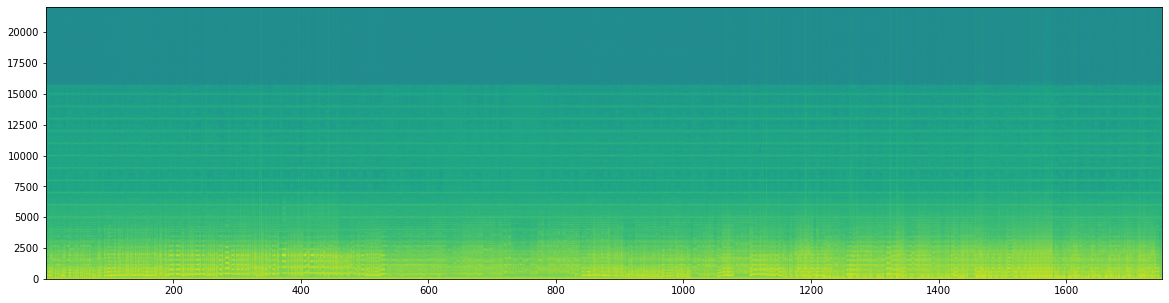

In [26]:
MS_1=Audio('/content/drive/My Drive/Projects/AA/Tonic_test/MS_189.mp3')
MS_2=Audio('/content/drive/My Drive/Projects/AA/Tonic_test/MS_190.mp3')
MS_3=Audio('/content/drive/My Drive/Projects/AA/Tonic_test/MS_191.mp3')

In [0]:
print(MS_1.tonic)
print(MS_2.tonic)
print(MS_3.tonic)

In [0]:
nithya_1=Audio('/content/drive/My Drive/Projects/AA/Tonic_test/Nithya_210.mp3')
nithya_2=Audio('/content/drive/My Drive/Projects/AA/Tonic_test/Nithya_211.mp3')
nithya_3=Audio('/content/drive/My Drive/Projects/AA/Tonic_test/Nithya_212.mp3')

In [0]:
print(nithya_1.tonic)
print(nithya_2.tonic)
print(nithya_3.tonic)

In [0]:
g,h = np.array(list(rkm_mohana.d_hist.items())).T

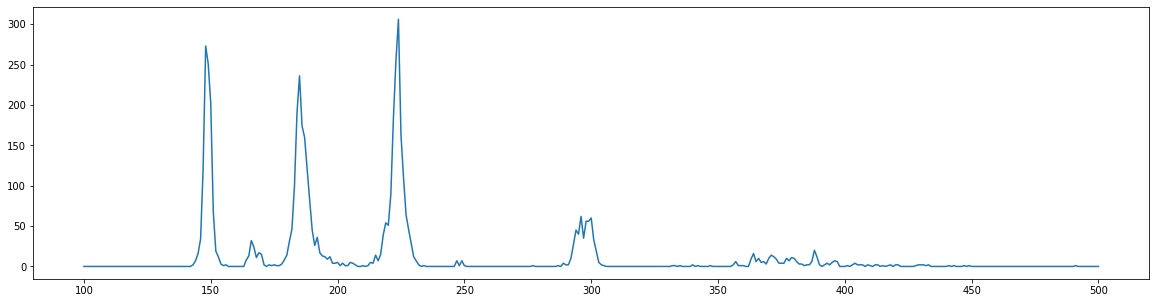

In [0]:
plt.plot(g,h)

In [0]:
max_key = max(rkm_abhogi.d_hist, key=rkm_abhogi.d_hist.get)

In [0]:
max_key

197

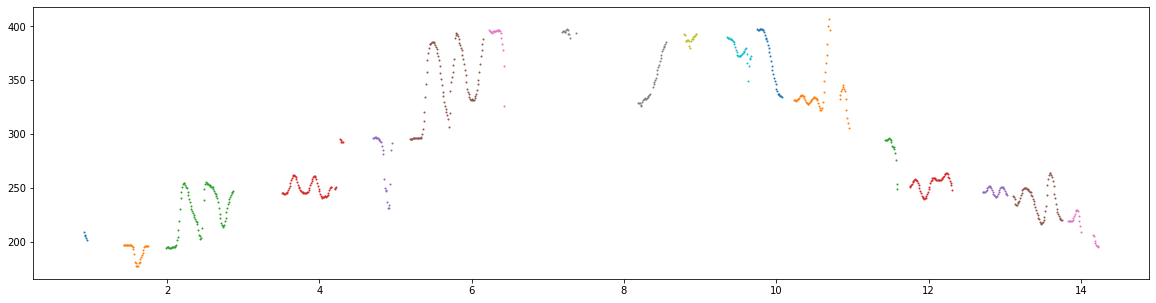

In [0]:
for i in range(len(shankarabarana.bt_cpn)):
  #print(h[i][-1]-h[i][0])
  plt.scatter(shankarabarana.bt_cpt[i],shankarabarana.bt_cpn[i],s = 1)

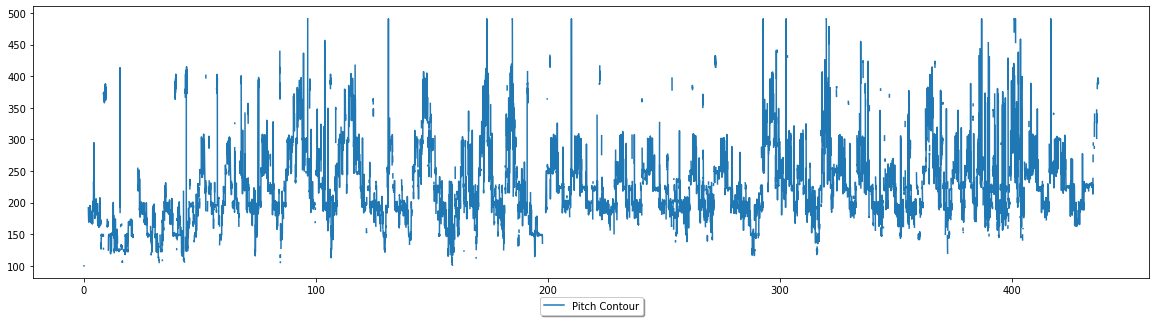

In [0]:
rkm_sahana.plot(contour  = True)

In [0]:
rkm_abhogi.find_all_notes()
rkm_kalyani.find_all_notes()
rkm_mohana.find_all_notes()
rkm_sahana.find_all_notes()